In [ ]:
import pandas as pd
import numpy as np
import os
import warnings
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)

DATA_DIR = '../data'
X_TRAIN_PATH = os.path.join(DATA_DIR, 'X_train.csv')
Y_TRAIN_PATH = os.path.join(DATA_DIR, 'y_train.csv')
X_TEST_PATH = os.path.join(DATA_DIR, 'X_test.csv')

X_train = pd.read_csv(X_TRAIN_PATH, index_col='ID')
y_train = pd.read_csv(Y_TRAIN_PATH, index_col='ID')
X_test = pd.read_csv(X_TEST_PATH, index_col='ID')

In [14]:
def add_sector_context(df_input):
    df = df_input.copy()

    df = df.fillna(0)

    ret_cols = [c for c in df.columns if 'RET_' in c]
    vol_cols = [c for c in df.columns if 'VOLUME_' in c]

    sector_daily_ret = df.groupby(['DATE', 'SECTOR'])[ret_cols].transform('mean')
    sector_daily_vol = df.groupby(['DATE', 'SECTOR'])[vol_cols].transform('mean')

    up = sector_daily_ret.clip(lower=0)
    down = -1 * sector_daily_ret.clip(upper=0)

    avg_gain = up.mean(axis=1)
    avg_loss = down.mean(axis=1)

    rs = avg_gain / (avg_loss + 1e-9)
    df['SECTOR_RSI'] = 100 - (100 / (1 + rs))

    weights = np.exp(np.linspace(-1., 0., len(ret_cols)))
    weights /= weights.sum()
    df['SECTOR_EMA'] = (sector_daily_ret * weights).sum(axis=1)

    adl_proxy = (sector_daily_ret * sector_daily_vol).mean(axis=1)
    df['SECTOR_ADL'] = adl_proxy

    df['STOCK_RET_MEAN'] = df[ret_cols].mean(axis=1)
    df['STOCK_RET_STD'] = df[ret_cols].std(axis=1)
    df['STOCK_VOL_MEAN'] = df[vol_cols].mean(axis=1)

    df['RET_vs_SECTOR'] = df['RET_1'] - df['SECTOR_EMA']

    return df

X_train_eng = add_sector_context(X_train)
X_test_eng = add_sector_context(X_test)

cols_to_drop = ['DATE', 'STOCK', 'SECTOR', 'INDUSTRY', 'INDUSTRY_GROUP', 'SUB_INDUSTRY']
X_train_final = X_train_eng.drop(columns=cols_to_drop)
X_test_final = X_test_eng.drop(columns=cols_to_drop)

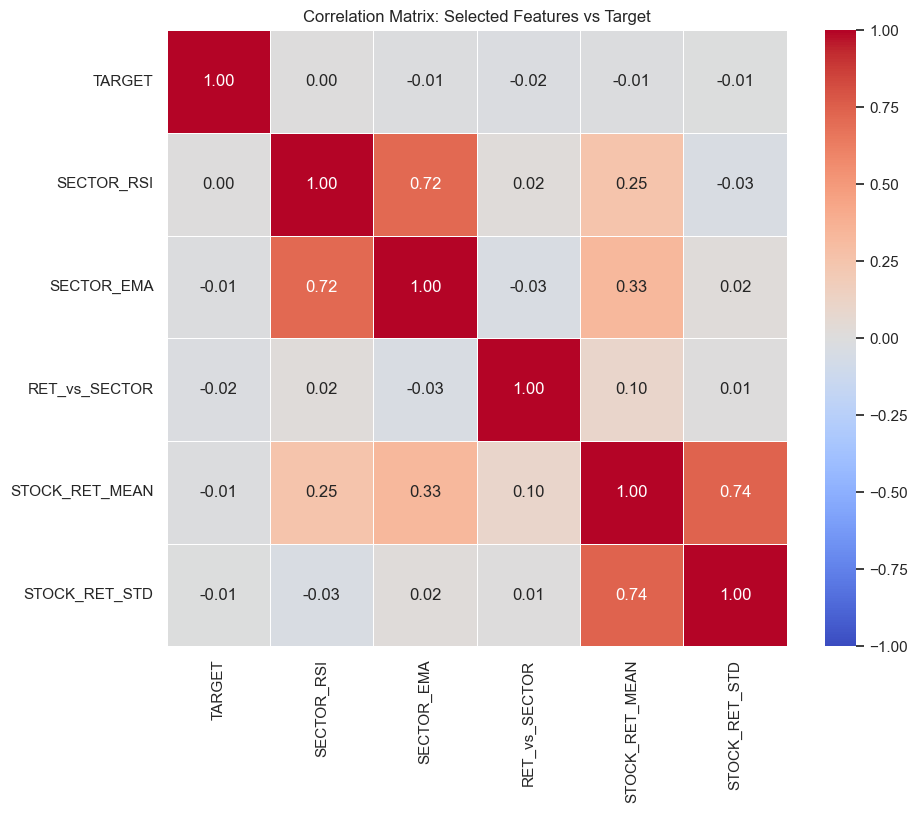

In [19]:
analysis_df = X_train_final.copy()
analysis_df['TARGET'] = y_train['RET']

cols_to_show = [
    'TARGET',
    'SECTOR_RSI',
    'SECTOR_EMA',
    'RET_vs_SECTOR',
    'STOCK_RET_MEAN',
    'STOCK_RET_STD'
]

corr_matrix = analysis_df[cols_to_show].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    vmin=-1, vmax=1
)
plt.title("Correlation Matrix: Selected Features vs Target")
plt.show()

In [15]:
X_train_final = X_train_final.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_final = X_test_final.replace([np.inf, -np.inf], np.nan).fillna(0)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

estimators = [
    ('rf', RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=4, random_state=SEED, n_jobs=-1)),
    ('et', ExtraTreesClassifier(n_estimators=300, max_depth=12, min_samples_leaf=4, random_state=SEED, n_jobs=-1)),
    ('xgb', XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.03, random_state=SEED, n_jobs=-1, eval_metric='logloss')),
    ('hgb', HistGradientBoostingClassifier(max_iter=200, max_depth=8, learning_rate=0.05, random_state=SEED)),
    ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.05, random_state=SEED))
]

voting_clf = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)
voting_clf.fit(X_train_scaled, y_train['RET'])

train_acc = voting_clf.score(X_train_scaled, y_train['RET'])
print(f"Accuracy: {train_acc:.4f}")

Accuracy: 0.5891


In [16]:
y_pred = voting_clf.predict(X_test_scaled)

submission = pd.DataFrame({
    'ID': X_test.index,
    'RET': y_pred
})

REPORTS_DIR = '../reports'
os.makedirs(REPORTS_DIR, exist_ok=True)
submission_path = os.path.join(REPORTS_DIR, 'final_submission.csv')

submission.to_csv(submission_path, index=False)